In [18]:
import pandas as pd
import numpy as np
import os,re,json
import geonamescache
from unidecode import unidecode

In [19]:
data = pd.read_json("data/headline_cities_and_countries.json")
data = data.replace({None: np.nan})
data = data.rename(columns=dict(countries="country", cities="city"))
data.head()

,headline,country,city
0,Zika Outbreak Hits Miami,NaN,Miami
1,Could Zika Reach New York City?,NaN,New York City
2,First Case of Zika in Miami Beach,NaN,Miami Beach
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife
4,Dallas man comes down with case of Zika,NaN,Dallas


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  650 non-null    object
 1   country   15 non-null     object
 2   city      608 non-null    object
dtypes: object(3)
memory usage: 15.4+ KB


In [21]:
data.describe()

,headline,country,city
count,650,15,608
unique,647,10,574
top,Spanish Flu Spreading through Madrid,Malaysia,Monroe
freq,2,3,4


In [22]:
data["headline"].value_counts().sort_values().tail()

Zika Troubles come to Greater Noida     1
Case of Malaria Reported in Aurora      1
Barcelona Struck by Spanish Flu         2
Spanish Flu Outbreak in Lisbon          2
Spanish Flu Spreading through Madrid    2
Name: headline, dtype: int64

In [23]:
print(f"There were {len(data)} rows before dropping duplicates.")
data = data.drop_duplicates()
print(f"There are {len(data)} rows after dropping duplicates.")

There were 650 rows before dropping duplicates.
There are 647 rows after dropping duplicates.


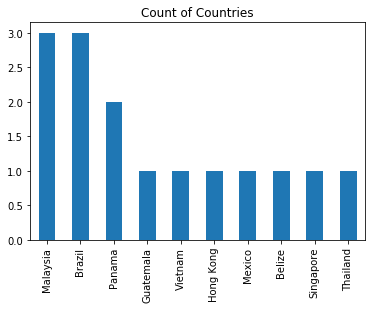

In [24]:
data['country'].value_counts().plot.bar(title='Count of Countries')

In [25]:
gc = geonamescache.GeonamesCache()

# Read in the saved unaccented:accented mapping
with open("data/city_accent_mapping.json", "r") as fin:
    city_accented_mapping = json.loads(fin.read())

# Create a column for accented cities
data["accented_city"] = data["city"].map(city_accented_mapping)
data[data["city"] != data["accented_city"]].head()

,headline,country,city,accented_city
7,Geneve Scientists Battle to Find Cure,NaN,Geneve,Genève
9,Zika Infested Monkeys in Sao Paulo,NaN,Sao Paulo,São Paulo
17,Louisiana Zika cases up to 26,NaN,NaN,NaN
19,Zika infects pregnant woman in Cebu,NaN,NaN,NaN
47,18 new Zika Cases in Bogota,NaN,Bogota,Bogotá


In [29]:
city_locations = []

# Go through all the accented cities
for city in data["accented_city"]:
    # Find matches (if any)
    matches = gc.get_cities_by_name(city)
    if matches:
        # Sort from largest to smallest population
        matches = [
            {k: v for k, v in list(match.values())[0].items()} for match in matches
        ]
        matches = sorted(matches, key=lambda x: x["population"], reverse=True)

        # Find the match with the largest population
        match = matches[0]

        # Record the information
        city_locations.append(
            {
                "name": match["name"],
                "latitude": match["latitude"],
                "longitude": match["longitude"],
                "countrycode": match["countrycode"],
                "pop": match["population"],
            }
        )

city_locations = pd.DataFrame(city_locations)
city_locations.head()

,name,latitude,longitude,countrycode,pop
0,Miami,25.77427,-80.19366,US,441003
1,New York City,40.71427,-74.00597,US,8175133
2,Miami Beach,25.79065,-80.13005,US,92312
3,Recife,-8.05389,-34.88111,BR,1478098
4,Dallas,32.78306,-96.80667,US,1300092


In [30]:
city_locations = city_locations.drop_duplicates()
print(f"We have the locations for {city_locations.shape[0]} unique cities.")

We have the locations for 574 unique cities.


In [31]:
data = pd.merge(
    data, city_locations, left_on="accented_city", right_on="name", how="left"
)
data.head()

,headline,country,city,accented_city,name,latitude,longitude,countrycode,pop
0,Zika Outbreak Hits Miami,NaN,Miami,Miami,Miami,25.77427,-80.19366,US,441003.0
1,Could Zika Reach New York City?,NaN,New York City,New York City,New York City,40.71427,-74.00597,US,8175133.0
2,First Case of Zika in Miami Beach,NaN,Miami Beach,Miami Beach,Miami Beach,25.79065,-80.13005,US,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,Recife,Recife,-8.05389,-34.88111,BR,1478098.0
4,Dallas man comes down with case of Zika,NaN,Dallas,Dallas,Dallas,32.78306,-96.80667,US,1300092.0


In [33]:
print(f"There were {len(data)} rows before dropping N/A city.")
ddata = data.dropna(subset=['name'])
print(f"There are {len(data)} rows after dropping N/A city.")

There were 605 rows before dropping N/A city.
There are 605 rows after dropping N/A city.


In [35]:
data.drop(columns=['name'],inplace=True)

In [37]:
data.to_csv('data/processed_headlines_locations.csv')